<a href="https://colab.research.google.com/github/HITSNINJA/Image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Jenis Buah

## Nama: Muhammad Zawawi Basri
## E-mail: zawawibasri@gmail.com
## ID-Dicoding: MC262D5Y2274

## Import Library

In [2]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

## Load Data

In [3]:
#Kaggle User
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d utkarshsaxenadn/fruits-classification

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification
License(s): CC0-1.0
  0% 0.00/84.8M [00:00<?, ?B/s]
100% 84.8M/84.8M [00:00<00:00, 1.41GB/s]


In [6]:
!unzip fruits-classification.zip -d fruits-classification

Streaming output truncated to the last 5000 lines.
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1950).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1952).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1953).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1955).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1956).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1957).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1958).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1959).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (196).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1960).jpeg  
  inflating: fruits-classification/Fruits Classification/tra

In [7]:
train_dir = "fruits-classification/Fruits Classification/train"
test_dir = "fruits-classification/Fruits Classification/test"

combined_dir = "fruits-classification/Fruits Classification/dataset"

In [8]:
os.makedirs(combined_dir, exist_ok=True)

In [9]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

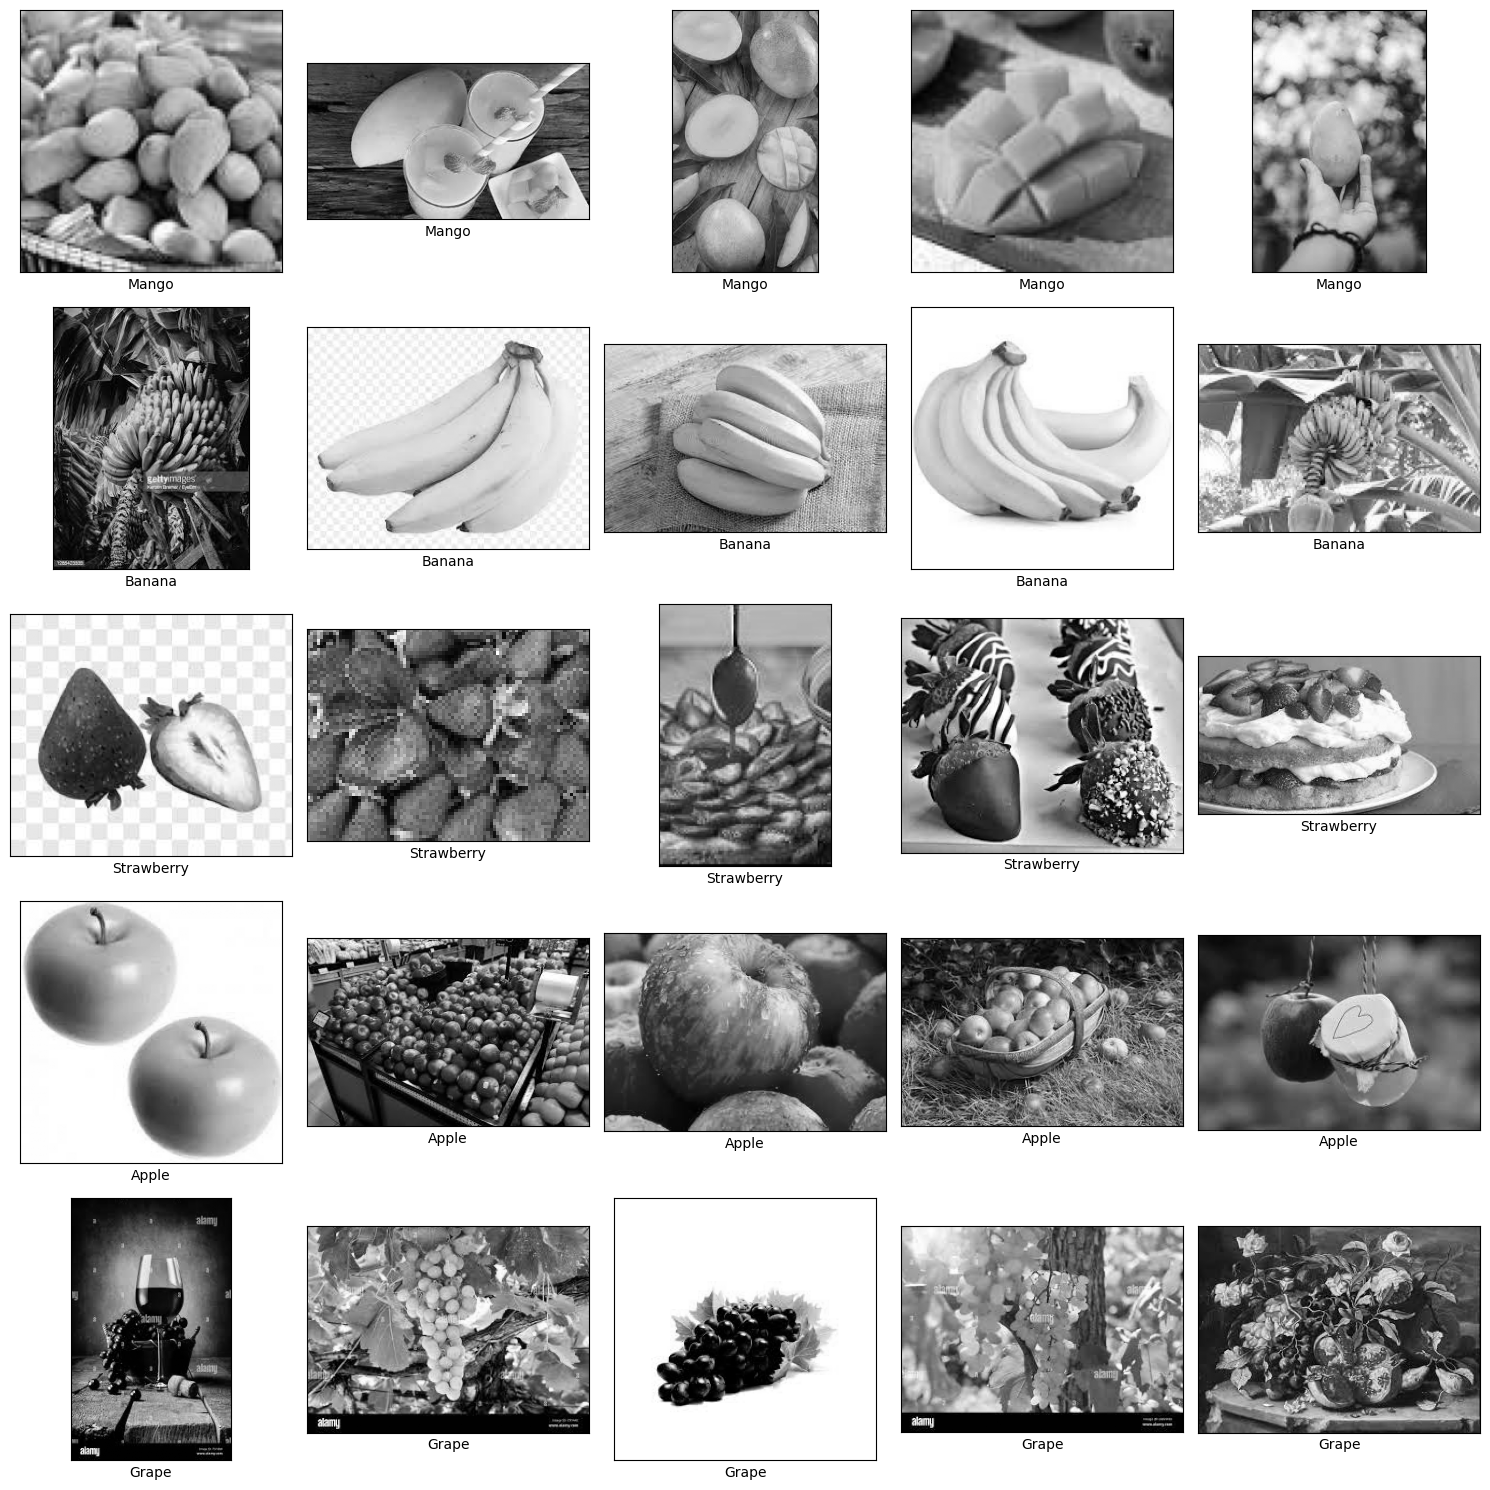

In [10]:
cards_image = {}

path = "fruits-classification/Fruits Classification/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    cards_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "fruits-classification/Fruits Classification/dataset/"

fig, axs = plt.subplots(len(cards_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(cards_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

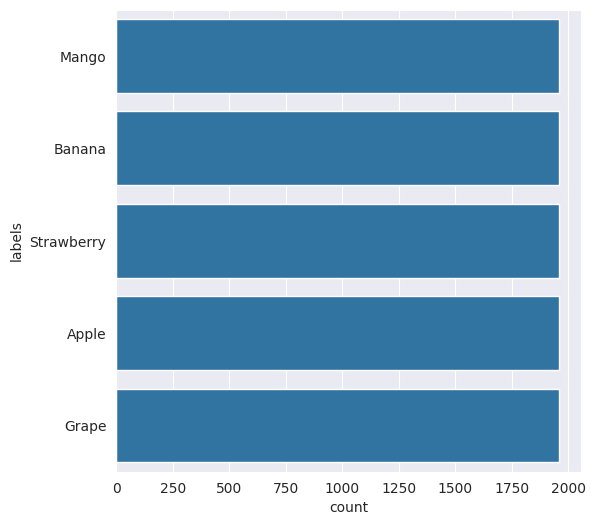

In [11]:
fruit_path = "fruits-classification/Fruits Classification/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(fruit_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)


In [12]:
mypath= 'fruits-classification/Fruits Classification/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

labels
Apple         1960
Banana        1960
Grape         1960
Mango         1960
Strawberry    1960
dtype: int64

## Preprocessing

### Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['path'], df['labels'], test_size=0.2, random_state=300
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=300
)

In [14]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'validation'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [15]:
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

print(df_all.groupby(['set', 'labels']).size(), '\n')

print(df_all.sample(5))

datasource_path = "fruits-classification/Fruits Classification/dataset/"

dataset_path = "Dataset-Final/"

set         labels    
test        Apple          371
            Banana         368
            Grape          406
            Mango          399
            Strawberry     416
train       Apple         1285
            Banana        1275
            Grape         1246
            Mango         1243
            Strawberry    1223
validation  Apple          304
            Banana         317
            Grape          308
            Mango          318
            Strawberry     321
dtype: int64 

                                                   path      labels    set
8157  fruits-classification/Fruits Classification/da...       Apple   test
8589  fruits-classification/Fruits Classification/da...      Banana   test
3695  fruits-classification/Fruits Classification/da...  Strawberry  train
680   fruits-classification/Fruits Classification/da...  Strawberry  train
7930  fruits-classification/Fruits Classification/da...       Apple   test


In [16]:
from tqdm import tqdm

for index, row in tqdm(df_all.iterrows()):

    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

9800it [00:02, 4481.42it/s]


In [17]:
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/validation/"
TEST_DIR = "Dataset-Final/test/"

fruit_classes = os.listdir(TRAIN_DIR)

for fruit_class in fruit_classes:
    train_path = os.path.join(TRAIN_DIR, fruit_class)
    val_path = os.path.join(VAL_DIR, fruit_class)  # Path validasi
    test_path = os.path.join(TEST_DIR, fruit_class)

    print(f"Total number of {fruit_class} images in training set: ", len(os.listdir(train_path)))
    print(f"Total number of {fruit_class} images in validation set: ", len(os.listdir(val_path)))  # Jumlah validasi
    print(f"Total number of {fruit_class} images in test set: ", len(os.listdir(test_path)))

Total number of Mango images in training set:  1243
Total number of Mango images in validation set:  318
Total number of Mango images in test set:  399
Total number of Banana images in training set:  1275
Total number of Banana images in validation set:  317
Total number of Banana images in test set:  368
Total number of Strawberry images in training set:  1223
Total number of Strawberry images in validation set:  321
Total number of Strawberry images in test set:  416
Total number of Apple images in training set:  1285
Total number of Apple images in validation set:  304
Total number of Apple images in test set:  371
Total number of Grape images in training set:  1246
Total number of Grape images in validation set:  308
Total number of Grape images in test set:  406


In [18]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

im_shape = (299, 299)
BATCH_SIZE = 16
seed = 10

food_classes = os.listdir(TRAIN_DIR)


train_generator = data_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    classes=food_classes
)

validation_generator = data_generator.flow_from_directory(
    VAL_DIR,
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    classes=food_classes
)

test_generator = data_generator.flow_from_directory(
    TEST_DIR,
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    classes=food_classes
)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples

classes = list(train_generator.class_indices.keys())
print('Classes: ' + str(classes))
num_classes = len(classes)

Found 6272 images belonging to 5 classes.
Found 1568 images belonging to 5 classes.
Found 1960 images belonging to 5 classes.
Classes: ['Mango', 'Banana', 'Strawberry', 'Apple', 'Grape']


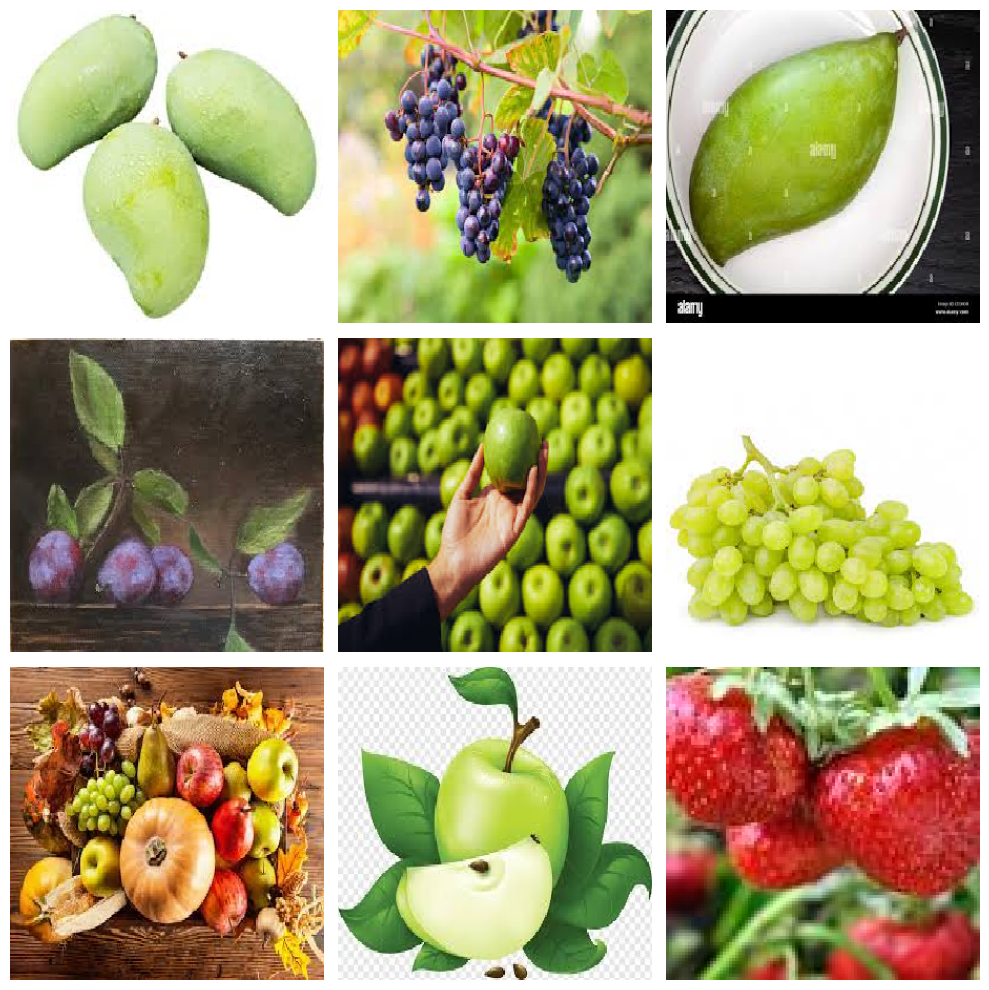

In [20]:

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = next(train_generator)[0]
    image = ((batch[0] + 1) / 2 * 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Modelling

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

model = Sequential([
    base_model,

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 8, 8, 64)       │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,000,677 (87.74 MB)

 Trainable params: 1,197,765 (4.57 MB)

 Non-trainable params: 21,802,912 (83.17 MB)

In [22]:
class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.95):
        super(StopAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n Akurasi mencapai {self.threshold*100:.0f}% pada train & val. Menghentikan training.")
                self.model.stop_training = True

In [23]:
stop_acc_callback = StopAtAccuracy(threshold=0.95)

In [24]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    ),
    stop_acc_callback
]

In [25]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.7259 - loss: 0.7875 - val_accuracy: 0.8763 - val_loss: 0.3785 - learning_rate: 9.0000e-05
Epoch 2/35
392/392 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.8800 - loss: 0.3691 - val_accuracy: 0.8782 - val_loss: 0.3515 - learning_rate: 9.0000e-05
Epoch 3/35
392/392 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.9071 - loss: 0.2757 - val_accuracy: 0.8992 - val_loss: 0.3192 - learning_rate: 9.0000e-05
Epoch 4/35
392/392 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.9258 - loss: 0.2244 - val_accuracy: 0.8948 - val_loss: 0.3088 - learning_rate: 9.0000e-05
Epoch 5/35
392/392 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.9451 - loss: 0.1807 - val_accuracy: 0.8814 - val_loss: 0.3531 - learning_rate: 9.0000e-05
Epoch 6/35
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9597 - loss: 0.1324
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.5000000682193786e-05.
392/392 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.

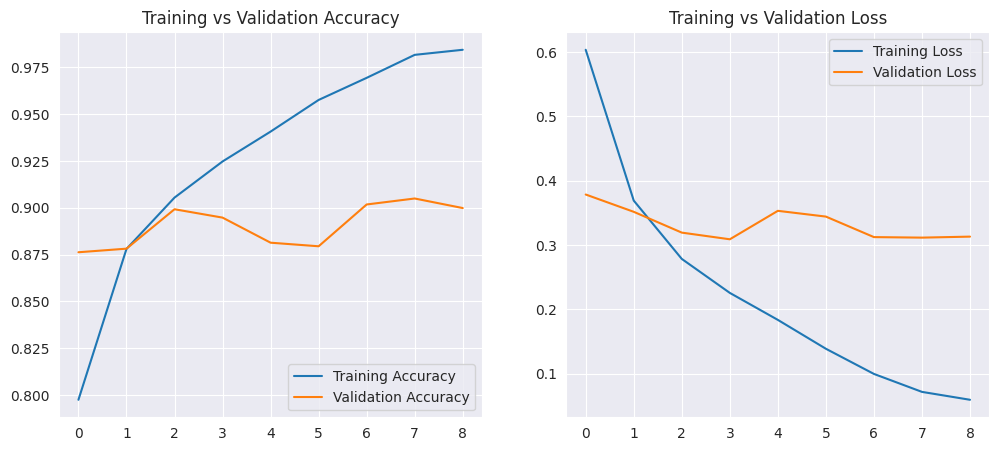

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [27]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training: {final_train_acc:.2%}")
print(f"Akurasi Validation: {final_val_acc:.2%}")

Akurasi Training: 98.44%
Akurasi Validation: 89.99%


In [28]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140509766952208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766954704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766953168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766955856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766955280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766955664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766956816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766956432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766956240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766952784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140509766957968

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [30]:
class_names = sorted(os.listdir(TRAIN_DIR))

with open("label.txt", "w") as f:
    for class_name in class_names:
        f.write(class_name + "\n")


In [31]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [32]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-05-23 19:34:12.770416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748028852.838064    3164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748028852.861666    3164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-23 19:34:25.073943: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748028865.077229    3164 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [33]:
from google.colab import drive

drive.mount('/content/drive')

os.makedirs('temp_model_dir', exist_ok=True)

shutil.move('model.tflite', 'temp_model_dir/model.tflite')
shutil.move('tfjs_model', 'temp_model_dir/tfjs_model')
shutil.move('saved_model', 'temp_model_dir/saved_model')
shutil.move('label.txt', 'temp_model_dir/label.txt')


Mounted at /content/drive


'temp_model_dir/label.txt'

In [34]:
drive_target = '/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

# Hapus folder tujuan di Drive jika sudah ada, lalu salin
if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree('temp_model_dir', drive_target)

'/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

## Inference

In [38]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path="temp_model_dir/model.tflite") # Change the model path to reflect new location
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

with open("temp_model_dir/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

Saving test_image_p.jpg to test_image_p (1).jpg


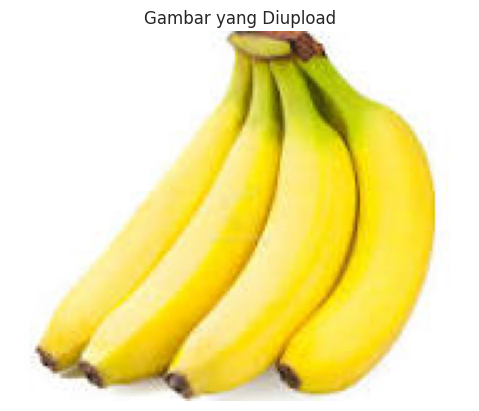

Predicted label: Banana


In [39]:
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

uploaded = files.upload()

filename = list(uploaded.keys())[0]

img_display = Image.open(filename)
plt.imshow(img_display)
plt.axis('off')
plt.title("Gambar yang Diupload")
plt.show()

img = img_display.resize((299, 299))
img = np.array(img, dtype=np.float32) / 255.0
img = np.expand_dims(img, axis=0)

interpreter = tf.lite.Interpreter(model_path="temp_model_dir/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)


print(f"Predicted label: {labels[predicted_class]}")
